In [1]:
import timeit
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [2]:
timer = timeit.Timer(setup='import numpy as np',
                     stmt='np.zeros((4, 4))')
timer.timeit(10)

9.979000424209516e-06

In [3]:
def bench_workload(workload):
    """Benchmark a workload

    workload: a method that accept a num_repeat argument
    and return its total execution time
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

print('time for np.zeros((4, 4)):', bench_workload(timer.timeit))

time for np.zeros((4, 4)): 1.5558526766788557e-07


In [4]:
def np_setup(n):
    return 'import numpy as np\n' \
           'x = np.random.normal(size=%d).astype("float32")\n' \
           'y = np.empty_like(x)\n'% n

def np_copy(n):
    return timeit.Timer(setup=np_setup(n),
                        stmt='np.copyto(y, x)')

sizes = 2**np.arange(5, 20, 4).astype('int')
exe_times = [bench_workload(np_copy(n).timeit) for n in sizes]

/tmp/ipykernel_7409/356713169.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


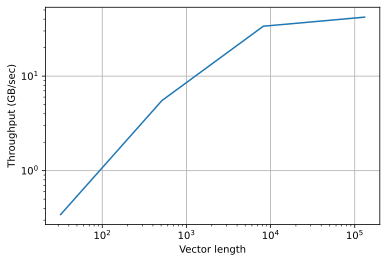

In [5]:
display.set_matplotlib_formats('svg')
# one float32 takes 4 bytes
plt.loglog(sizes, sizes*4/exe_times/1e9)
plt.xlabel('Vector length')
plt.ylabel('Throughput (GB/sec)')
plt.grid()

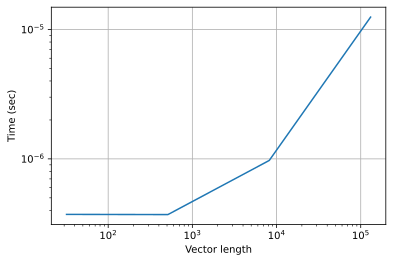

In [6]:
plt.loglog(sizes, exe_times)
plt.xlabel('Vector length')
plt.ylabel('Time (sec)')
plt.grid()

In [7]:
sizes = 2**np.arange(1, 8).astype('int')
exe_times = np.array([bench_workload(np_copy(n).timeit) for n in sizes])

print('NumPy call overhead: %.1f microsecond' % (exe_times.mean()*1e6))

NumPy call overhead: 0.4 microsecond


In [8]:
def tvm_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import tvm\n'
                        'x, y = tvm.nd.array(x), tvm.nd.array(y)',
                        stmt='x.copyto(y)')

tvm_times = np.array([bench_workload(tvm_copy(n).timeit) for n in sizes])
print('TVM call overhead: %.1f microsecond'% (tvm_times.mean()*1e6,))

TVM call overhead: 0.4 microsecond


In [9]:
def mx_copy(n):
    return timeit.Timer(setup=np_setup(n)+'import mxnet as mx\n'
                        'x, y = mx.nd.array(x), mx.nd.array(y)\n'
                        'mx.nd.waitall()'% n,
                        stmt='x.copyto(y); y.wait_to_read()')

mx_times = np.array([bench_workload(mx_copy(n).timeit) for n in sizes])
print('MXNet call overhead: %.1f microsecond'% (mx_times.mean()*1e6,))

MXNet call overhead: 17.9 microsecond
